# Proyecto Data Science

## Estimación de la producción acumulada de petróleo y gas

<font color='Black' size='4px'>Realizado por Rafael Marcano</font>

## Introducción

<font color='Black' size='4px'>Este proyecto trata de realizar la estimación de la producción petrolera.</font>

<font color='Black' size='4px'>En los datos encontramos secuencias de longitud arbitraria por lo tanto se usará redes neuronales recurrentes (RNN).</font>

<font color='Black' size='4px'>Con tensorflow y Keras en general se hará la construcción del modelo</font>

## Librerias

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from productionScript import Production
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [2]:
root = "/home/rafael/Documentos/Produccion_Petrolera_Data/DATALOGGER/"
fileNames = "productionList.txt"

In [3]:
class Read:
    def __init__(self, year):
        self.year = year

    def documents(self):
        filesList = []
        commandLine = "ls " + root + str(self.year) + " > " + fileNames
        try:
            os.system(commandLine)
            file = pd.read_csv(fileNames, sep="\t", header= None, squeeze=True)
            for element in file:
                filesList.append(root + str(self.year) + "/" + element)
        except FileNotFoundError as fnf_error:
            print(fnf_error)
        return filesList

In [4]:
class Data:
    def __init__(self, year):
        self.year = year
        self.documents = Read(year).documents()
        
    def load(self):
        content = []
        headers = []
        count = 0
        try:
            for element in self.documents:
                count += 1
                # print("Reading file n° {} ...".format(count))
                columns = ["Date", "Time"]
                data = []
                file = pd.read_csv(element, sep="\t", header= None, squeeze=True)
                obj = pd.DataFrame(file)
            #     # Reading current document
                for line in file:
                    data += [line.split()]
                content.append(data)
                cols = obj.loc[obj[0].str.contains('Tool')]
                size = list(range(0, len(cols)))
                for k in size:
                    for names in ["Press", "Temp"]:
                        columns.append(names + " " + cols[0].tolist()[k].split()[4:][1])
                headers.append(columns)
        except:
            print("No se puedo obtener datos del directorio ", element)
        return [content, headers]

In [5]:
class Frame:
    def __init__(self, year):
        self.year = year
        self.load = Data(self.year).load()
        self.data_headers = self.load[1]
        self.data = self.load[0]
        
    def build(self, well):
        target = "Press {}".format(well)
        frames = []
        # Getting content index
        for current_headers in self.data_headers:
            if target in current_headers:
                frame_targets = [i for i,x in enumerate(self.data_headers) if x==current_headers]
        # Building data frame
        try:
            for k in frame_targets:
                columnsRanges = list(range(0,len(self.data_headers[k])))
                frame = pd.DataFrame(self.data[k]).iloc[:,columnsRanges]
                index = frame[frame[0] == "DATE"].index
                obj = frame.drop(range(0,index[0]+int(4)))
                obj[0] = pd.to_datetime(obj[0], infer_datetime_format=True)
                obj[1] = pd.to_timedelta(obj[1])
                obj.columns = self.data_headers[k]
                frames.append(obj)
                # print("Building data frames ...")
        except AssertionError as error:
            print(error)
        return frames

In [6]:
class Parameters:
    def __init__(self, well, year):
        self.year = year
        self.well = well
        self.frames = Frame(self.year).build(self.well)

    def getWell(self):
        data = []
        frame = []
        try:
            data = pd.concat(self.frames)
            columns = ["Date", "Press " + self.well, "Temp " + self.well]
            frame = pd.DataFrame(data[columns])
            #frame[["Press " + self.well, "Temp " + self.well]] = frame[["Press " + self.well, "Temp " + self.well]].astype(float)
            # well_data = frame.groupby(["Date"]).mean().dropna()
            print("DataFrame {} creado exitosamente.".format(self.well))
        except AssertionError as error:
            print(error)
        return frame

# Carga de datos

## Pozo AP-01

<font color='Black' size='4px'>Obteniendo parametros de presión y temperatura</font>

In [7]:
param_AP01_2009 = Parameters('AP-01', 2009)
param_AP01_2009 = param_AP01_2009.getWell()
prod_AP01 = Production('AP-01')
well_prod_ap01 = prod_AP01.Frame()

DataFrame AP-01 creado exitosamente.


<font color='Black' size='4px'>Uniendo data parametros y producción en un solo Data Frame</font>

In [8]:
well_prod_ap01.columns = ["Date", "Oil", "Gas"]
well_prod_ap01["Date"] = pd.to_datetime(well_prod_ap01["Date"], infer_datetime_format=True)
data_set = pd.merge(param_AP01_2009, well_prod_ap01, on="Date")

In [9]:
data_set.describe()

,Date,Press AP-01,Temp AP-01,Oil,Gas
count,1070662,1070662,1070662,1.070662e+06,1.070662e+06
unique,333,17599,4,3.310000e+02,3.310000e+02
top,2009-01-25 00:00:00,2322.410,156.000,1.441532e+06,7.503989e+08
freq,5764,10065,549581,5.764000e+03,5.764000e+03
first,2009-01-08 00:00:00,NaN,NaN,NaN,NaN
last,2010-01-02 00:00:00,NaN,NaN,NaN,NaN


In [10]:
#start_date = '2009-01-01'
#end_date = '2009-12-31'
#mask = (well_prod_ap01['Date'] > start_date) & (well_prod_ap01['Date'] <= end_date)
#well_prod_ap01 = well_prod_ap01.loc[mask]

<font color='Black' size='4px'>Formateando el tipo de datos.</font>

In [11]:
data_set[["Press AP-01", "Temp AP-01", "Oil", "Gas"]] = data_set[["Press AP-01", "Temp AP-01", "Oil", "Gas"]].astype(float)
data_set = data_set.groupby("Date").mean().dropna()

<font color='black' size='4px'>Trazos de relaciones por pares del conjunto de datos</font>


/home/rafael/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


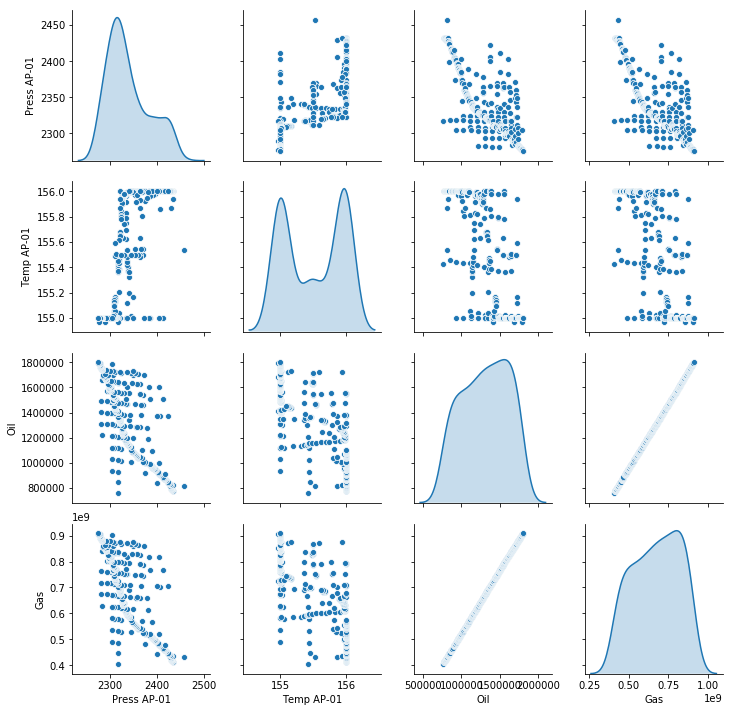

In [12]:
g = sns.pairplot(data_set, diag_kind="kde")

<font color='Black' size='4px'>Datos estadísticos</font>

In [13]:
data_set.describe()

,Press AP-01,Temp AP-01,Oil,Gas
count,333.000000,333.000000,3.330000e+02,3.330000e+02
mean,2339.045064,155.511013,1.313470e+06,6.744679e+08
std,43.992218,0.438133,2.984554e+05,1.449765e+08
min,2275.965305,154.969134,7.597161e+05,4.051087e+08
25%,2307.189695,155.000000,1.064799e+06,5.533765e+08
50%,2326.360590,155.500000,1.333060e+06,6.854821e+08
75%,2364.612697,155.997917,1.571881e+06,8.017503e+08
max,2456.862776,156.000000,1.800650e+06,9.085322e+08


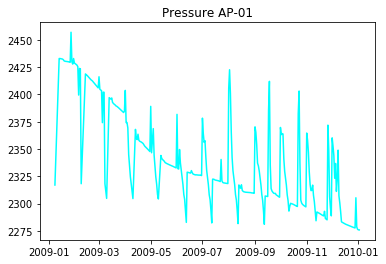

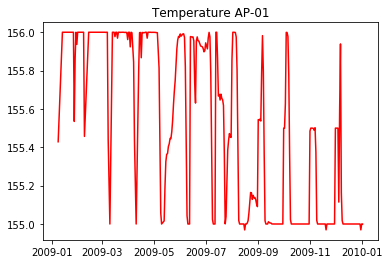

In [14]:
plt.figure()
plt.title('Pressure AP-01')
plt.plot(data_set['Press AP-01'], 'cyan')
plt.figure()
plt.title('Temperature AP-01')
plt.plot(data_set['Temp AP-01'], 'red')

In [15]:
data_set.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 333 entries, 2009-01-08 to 2010-01-02
Data columns (total 4 columns):
Press AP-01    333 non-null float64
Temp AP-01     333 non-null float64
Oil            333 non-null float64
Gas            333 non-null float64
dtypes: float64(4)
memory usage: 23.0 KB


<font color='Black' size='4px'>Gráficas de los valores de producción</font>

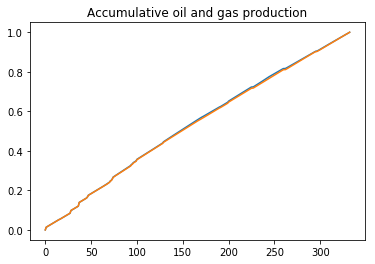

In [16]:
from sklearn.preprocessing import MinMaxScaler

maft_oil = data_set['Oil']
matf_press = data_set['Gas']

matf_press = matf_press.values.reshape(len(matf_press), 1)
maft_oil = maft_oil.values.reshape(len(maft_oil), 1)

# Normalización de los datos

sc = MinMaxScaler(feature_range=(0,1))

maft_oil = sc.fit_transform(maft_oil)
matf_press = sc.fit_transform(matf_press)

plt.title('Accumulative oil and gas production')
plt.plot(matf_press)
plt.plot(maft_oil)
plt.show()

In [17]:
dataset = data_set.iloc[:,0:3].values
dataset = sc.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.67) 
test_size = len(dataset) - train_size

train, test = dataset[test_size:len(dataset)], dataset[train_size:len(dataset)]

In [18]:
print("Train and Test shape {} {}".format(train.shape, test.shape))

Train and Test shape (223, 3) (110, 3)


<font color='Black' size='4px'>Normalización de los datos</font>

In [31]:
X_train, y_train = [], []
for i in range(60, len(train)):
    X_train.append(train[i-60:i,0])
    y_train.append(train[i,2:3])

In [32]:
X_train, y_train = np.array(X_train), np.array(y_train)

In [33]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [34]:
X_train.shape

(163, 60, 1)

<font color='#232323' size='5px'>Recurrent Neural Network Model</font>

In [35]:
# Model
regresor = Sequential()
# Layers
regresor.add(LSTM(50, return_sequences = True, input_shape=(60,1)))
regresor.add(Dropout(.2))
regresor.add(LSTM(50, return_sequences = True))
regresor.add(Dropout(.2))
regresor.add(LSTM(50, return_sequences = False))
regresor.add(Dense(1))
#Optimizer
from tensorflow.keras.optimizers import Adam
opt = Adam(lr=1e-3, decay=1e-5)
# Compile
regresor.compile(optimizer=opt, loss='mean_squared_error', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [36]:
# Entrenamiento
history = regresor.fit(X_train, y_train, epochs = 200, batch_size=32)

Instructions for updating:
Use tf.cast instead.
Epoch 1/200
163/163 [==============================] - 5s 32ms/sample - loss: 0.4770 - acc: 0.0000e+00
Epoch 2/200
163/163 [==============================] - 1s 7ms/sample - loss: 0.1108 - acc: 0.0061
Epoch 3/200
163/163 [==============================] - 1s 8ms/sample - loss: 0.0498 - acc: 0.0000e+00
Epoch 4/200
163/163 [==============================] - 1s 8ms/sample - loss: 0.0535 - acc: 0.0000e+00
Epoch 5/200
163/163 [==============================] - 1s 7ms/sample - loss: 0.0378 - acc: 0.0061
Epoch 6/200
163/163 [==============================] - 1s 7ms/sample - loss: 0.0346 - acc: 0.0061
Epoch 7/200
163/163 [==============================] - 1s 7ms/sample - loss: 0.0340 - acc: 0.0061
Epoch 8/200
163/163 [==============================] - 1s 8ms/sample - loss: 0.0291 - acc: 0.0061
Epoch 9/200
163/163 [==============================] - 1s 8ms/sample - loss: 0.0291 - acc: 0.0061
Epoch 10/200
163/163 [==============================] - 1

163/163 [==============================] - 1s 8ms/sample - loss: 0.0020 - acc: 0.0061
Epoch 82/200
163/163 [==============================] - 1s 8ms/sample - loss: 0.0020 - acc: 0.0061
Epoch 83/200
163/163 [==============================] - 1s 8ms/sample - loss: 0.0011 - acc: 0.0061
Epoch 84/200
163/163 [==============================] - 1s 8ms/sample - loss: 0.0012 - acc: 0.0061
Epoch 85/200
163/163 [==============================] - 1s 8ms/sample - loss: 0.0012 - acc: 0.0061
Epoch 86/200
163/163 [==============================] - 1s 8ms/sample - loss: 0.0027 - acc: 0.0061
Epoch 87/200
163/163 [==============================] - 1s 8ms/sample - loss: 0.0011 - acc: 0.0061
Epoch 88/200
163/163 [==============================] - 1s 8ms/sample - loss: 0.0014 - acc: 0.0061
Epoch 89/200
163/163 [==============================] - 1s 8ms/sample - loss: 0.0015 - acc: 0.0061
Epoch 90/200
163/163 [==============================] - 1s 8ms/sample - loss: 9.9960e-04 - acc: 0.0061
Epoch 91/200
163/16

163/163 [==============================] - 1s 8ms/sample - loss: 0.0013 - acc: 0.0061
Epoch 163/200
163/163 [==============================] - 1s 8ms/sample - loss: 0.0014 - acc: 0.0061
Epoch 164/200
163/163 [==============================] - 1s 8ms/sample - loss: 0.0026 - acc: 0.0061
Epoch 165/200
163/163 [==============================] - 1s 8ms/sample - loss: 0.0017 - acc: 0.0061
Epoch 166/200
163/163 [==============================] - 1s 8ms/sample - loss: 0.0010 - acc: 0.0061
Epoch 167/200
163/163 [==============================] - 1s 8ms/sample - loss: 9.8266e-04 - acc: 0.0061
Epoch 168/200
163/163 [==============================] - 1s 8ms/sample - loss: 0.0013 - acc: 0.0061
Epoch 169/200
163/163 [==============================] - 1s 8ms/sample - loss: 0.0014 - acc: 0.0061
Epoch 170/200
163/163 [==============================] - 1s 8ms/sample - loss: 0.0015 - acc: 0.0061
Epoch 171/200
163/163 [==============================] - 1s 8ms/sample - loss: 0.0011 - acc: 0.0061
Epoch 172/

In [37]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,acc,epoch
195,0.000920,0.006135,195
196,0.000869,0.006135,196
197,0.001288,0.006135,197
198,0.000677,0.006135,198
199,0.000666,0.006135,199


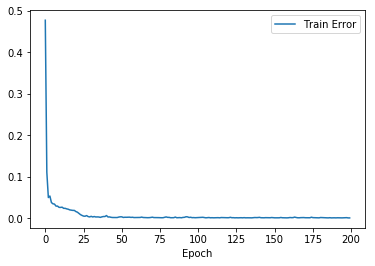

In [38]:
import matplotlib.pyplot as plt

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.plot(hist['epoch'], hist['loss'],
               label='Train Error')
    plt.legend()
    plt.show()

plot_history(history)

In [137]:
#prod_AP01 = Production('AP-03')
# Contrucción del frame para valores de producción
#well_prod_ap01 = prod_AP01.Frame()

In [51]:
y_test = []
for i in range(60, len(test)):
    y_test.append(test[i-60:i,0])

y_test = np.array(y_test)
y_test = np.reshape(y_test, (y_test.shape[0], y_test.shape[1], 1))

In [52]:
#well_prod_ap01.columns = ["Date", "Oil", "Gas"]
#well_prod_ap01["Date"] = pd.to_datetime(well_prod_ap01["Date"], infer_datetime_format=True)

In [53]:
#well_prod_ap01[["Oil"]] = well_prod_ap01[["Oil"]].astype(float)
#data_test = well_prod_ap01.groupby("Date").mean().dropna()

In [54]:
#data_test = pd.DataFrame(data_test.sample(frac=0.3, random_state=0))

#inputs = data_test.iloc[:,2:3].values

#inputs = inputs.reshape(-1, 1)
#inputs = sc.fit_transform(inputs)

In [55]:
#X_test = []
#for i in range(60, len(test)):
#    X_test.append(test[i-60:i,0])

#X_test = np.array(X_test)
#X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_prices = regresor.predict(y_test)

In [56]:
oil_predicted = []

for y_predicted in predicted_prices:
    oil_predicted.append(y_predicted[0])

oil_predicted = np.array(oil_predicted)

In [68]:
test_real = np.array(test[:,2:3])
test_real = test_real.reshape(-1,1)

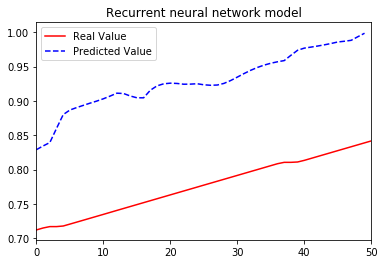

In [69]:
# Gráficas
plt.figure()
plt.title('Recurrent neural network model')
plt.plot(test_real, color='red', label='Real Value')
plt.plot(oil_predicted, 'k--', color='blue', label='Predicted Value')
plt.legend()
plt.xlim(0, len(oil_predicted))
plt.show()